## 0.1 imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style
import datetime as dt
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
from typing import List
from google.cloud import bigquery, storage


In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset

# 1. Load the raw data

#### **Collected data**

#### 📌 Tempelhofer Feld, Berlin, Germany

<iframe src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d26842.24808091901!2d13.400488957085193!3d52.477045271245125!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x47a84fe8f7d899eb%3A0x88898e99acbb718b!2sTempelhofer%20Feld!5e0!3m2!1sen!2sde!4v1736167638260!5m2!1sen!2sde" width="1200" height="450" style="border:0;" allowfullscreen="" loading="lazy" referrerpolicy="no-referrer-when-downgrade"></iframe>


### ☀️ 1. Historical photovoltaic production data
* 42 years (1980 - 2022)
* hourly resolution
* synthetic data derived from measured irradiance data
* ~ 400 000 data points
* source: [Renewables.ninja](https://www.renewables.ninja/about "Renewables.ninja")

### 🌡️ 2. Historical weather forecast data
* 6 1/2 years (Oct 2017 - Mar 2024)
* 4 model recalculation cycles available for each day (updated at: 00:00 UTC, 06:00 UTC, 12:00 UTC, 18:00 UTC)
* Each 16 days forecast in hourly resolution
* ~ 3.3 M rows - 24 Features
* source: [OpenWeather](https://openweathermap.org/api/history-forecast-bulk "History-forecast-bulk") (40 €)


In [4]:
pv_data = pd.read_csv('./data/1980-2022_pv.csv', memory_map=True)
forecast_data = pd.read_csv('./data/openweather_history_bulk_forecast_tempelhof.csv', memory_map=True)

# 2. Check the data

## 2.1 Photovolatic data

In [5]:
pv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376944 entries, 0 to 376943
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0.1        376944 non-null  int64  
 1   Unnamed: 0          376944 non-null  int64  
 2   local_time          376944 non-null  object 
 3   electricity         376944 non-null  float64
 4   irradiance_direct   376944 non-null  float64
 5   irradiance_diffuse  376944 non-null  float64
 6   temperature         376944 non-null  float64
 7   source              376944 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 23.0+ MB


In [6]:
pv_data.isna().sum()

Unnamed: 0.1          0
Unnamed: 0            0
local_time            0
electricity           0
irradiance_direct     0
irradiance_diffuse    0
temperature           0
source                0
dtype: int64

In [7]:
pv_data.isnull().sum()

Unnamed: 0.1          0
Unnamed: 0            0
local_time            0
electricity           0
irradiance_direct     0
irradiance_diffuse    0
temperature           0
source                0
dtype: int64

In [8]:
pv_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0.1,376944.0,4.382576e+03,2.530581e+03,0.000000e+00,2.191000e+03,4.383000e+03,6.574000e+03,8.783000e+03
Unnamed: 0,376944.0,9.940302e+11,3.917322e+11,3.155328e+11,6.547815e+11,9.940302e+11,1.333279e+12,1.672528e+12
electricity,376944.0,1.345303e-01,2.148500e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,9.000000e-01
irradiance_direct,376944.0,1.068965e-01,2.120717e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.700000e-02,1.016000e+00
irradiance_diffuse,376944.0,5.566084e-02,7.542225e-02,0.000000e+00,0.000000e+00,4.000000e-03,1.020000e-01,3.580000e-01
temperature,376944.0,9.219034e+00,9.013729e+00,-2.745800e+01,2.217000e+00,8.863000e+00,1.591600e+01,3.875600e+01


### 2.1.1 check for time gaps in data

In [9]:
# number of rows with unique values in our data
local_time_series = pd.to_datetime(pv_data['local_time'], utc= True)

unique_timestamps_pv_dataset = local_time_series.nunique()
unique_timestamps_pv_dataset

376944

In [10]:
# number of rows with unique values of a synthetic data with the same range
min_date = local_time_series.min()
max_date = local_time_series.max()
unique_timestamps_pv_dataset_theoretical = pd.date_range(start= min_date, end= max_date, freq=dt.timedelta(hours=1.0)).nunique()
unique_timestamps_pv_dataset_theoretical

376944

In [11]:
try:
    assert unique_timestamps_pv_dataset == unique_timestamps_pv_dataset_theoretical
    print('all good! there are no gaps in your dataset...')
except AssertionError:
    print('there are gaps in your dataset')

all good! there are no gaps in your dataset...


# 3. Preprocess the data

## 3.1 Photovolatic data

In [12]:
pv_data.head()

,Unnamed: 0.1,Unnamed: 0,local_time,electricity,irradiance_direct,irradiance_diffuse,temperature,source
0,0,315532800000,1980-01-01 01:00:00+01:00,0.0,0.0,0.0,-1.296,data/pv_data/1980_pv.csv
1,1,315536400000,1980-01-01 02:00:00+01:00,0.0,0.0,0.0,-1.216,data/pv_data/1980_pv.csv
2,2,315540000000,1980-01-01 03:00:00+01:00,0.0,0.0,0.0,-1.005,data/pv_data/1980_pv.csv
3,3,315543600000,1980-01-01 04:00:00+01:00,0.0,0.0,0.0,-1.063,data/pv_data/1980_pv.csv
4,4,315547200000,1980-01-01 05:00:00+01:00,0.0,0.0,0.0,-1.227,data/pv_data/1980_pv.csv


In [13]:
def time_encoding(X: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
        X (pd.DataFrame): datafrane to transform

    Returns:
        DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    local_time = pd.to_datetime(X.pop(column_name), utc= True)
    timestamp_s = local_time.map(pd.Timestamp.timestamp)


    day = 24*60*60
    year = (365.2425)*day
    X['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    X['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    X['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    X['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return X.iloc[:,-4:]


time_encoder = FunctionTransformer(time_encoding, kw_args={'column_name': 'local_time'})

pv_transformer = ColumnTransformer(
    [
        ('Time Encoder', time_encoder, ['local_time']),
        ('Passthrough', 'passthrough', ['local_time', 'electricity' ]),
    ],
    remainder='drop'
).set_output(transform='pandas')

preprocess_pv = Pipeline([('Time Features', pv_transformer)])
pv_processed = preprocess_pv.fit_transform(pv_data)

pv_processed.columns = [column.split('__')[1] for column in pv_processed.columns]
pv_processed

/home/jerome-roeser/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,day_sin,day_cos,year_sin,year_cos,local_time,electricity
0,3.844949e-13,1.000000,-0.007311,0.999973,1980-01-01 01:00:00+01:00,0.0
1,2.588190e-01,0.965926,-0.006594,0.999978,1980-01-01 02:00:00+01:00,0.0
2,5.000000e-01,0.866025,-0.005878,0.999983,1980-01-01 03:00:00+01:00,0.0
3,7.071068e-01,0.707107,-0.005161,0.999987,1980-01-01 04:00:00+01:00,0.0
4,8.660254e-01,0.500000,-0.004444,0.999990,1980-01-01 05:00:00+01:00,0.0
...,...,...,...,...,...,...
376939,-9.659258e-01,0.258819,-0.001047,0.999999,2022-12-31 20:00:00+01:00,0.0
376940,-8.660254e-01,0.500000,-0.000330,1.000000,2022-12-31 21:00:00+01:00,0.0
376941,-7.071068e-01,0.707107,0.000387,1.000000,2022-12-31 22:00:00+01:00,0.0
376942,-5.000000e-01,0.866025,0.001104,0.999999,2022-12-31 23:00:00+01:00,0.0


<AxesSubplot:xlabel='variable', ylabel='value'>

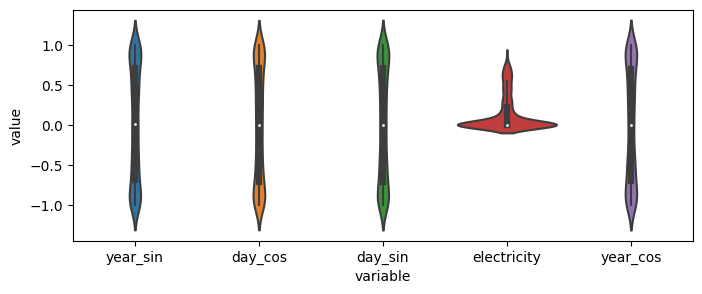

In [14]:
num_cols_pv = pv_processed.select_dtypes(include=np.number).columns
melted_pv_df = pd.melt(pv_processed[num_cols_pv])

plt.figure(figsize=(8, 3))
sns.violinplot(data=melted_pv_df.sample(10_000), x='variable', y='value')

In [15]:
column_indices = {name:i for i, name in enumerate(pv_processed.columns)}
column_indices

{'day_sin': 0,
 'day_cos': 1,
 'year_sin': 2,
 'year_cos': 3,
 'local_time': 4,
 'electricity': 5}

## 3.2 Weather forecast data

In [16]:
forecast_data.head()

,forecast dt unixtime,forecast dt iso,slice dt unixtime,slice dt iso,lat,lon,temperature,dew_point,pressure,ground_pressure,...,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,1507334400,2017-10-07 00:00:00 +0000 UTC,1507334400,2017-10-07 00:00:00 +0000 UTC,52.47,13.4,9.07,7.75,1015.81,1010.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00
1,1507334400,2017-10-07 00:00:00 +0000 UTC,1507338000,2017-10-07 01:00:00 +0000 UTC,52.47,13.4,9.49,7.62,1015.75,1010.19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.04
2,1507334400,2017-10-07 00:00:00 +0000 UTC,1507341600,2017-10-07 02:00:00 +0000 UTC,52.47,13.4,9.64,7.68,1015.80,1010.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.03
3,1507334400,2017-10-07 00:00:00 +0000 UTC,1507345200,2017-10-07 03:00:00 +0000 UTC,52.47,13.4,9.63,7.85,1015.91,1010.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.00
4,1507334400,2017-10-07 00:00:00 +0000 UTC,1507348800,2017-10-07 04:00:00 +0000 UTC,52.47,13.4,9.61,8.02,1016.03,1010.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000008,0.00


In [17]:
def compress(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum() / 1024
    print("dataframe size: ", round(input_size,2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")

    return df

def clean_forecast_data(forecast_df: pd.DataFrame) -> pd.DataFrame:
    """
    Initial has 3.3 M entries (everyday: 4 forecasts of 16 days ahead)
    Cleaning it to: - 1 forecast perday (at 12:00)
                    - 48 hours a day
                    - right now hardcoded to match last forecast day with
                     last day of PV data
    """
    df = compress(forecast_df)
    df = df.drop(columns=['lat', 'lon',
                          'forecast dt iso',
                          'slice dt iso'])

    df.rename(columns={'forecast dt unixtime':'utc_time',
                        'slice dt unixtime':'prediction_utc_time'},
                        inplace=True)

    # df['utc_time'] = df['utc_time'].str.replace('+0000 UTC', '')
    # df['prediction_utc_time'] = df['prediction_utc_time'].str.replace('+0000 UTC', '')

    df['utc_time'] = pd.to_datetime(df['utc_time'], unit= 's', utc= True)
    df['prediction_utc_time'] = pd.to_datetime(df['prediction_utc_time'], unit= 's', utc= True)

    # # get only 1 forecast per day
    df = df[df['utc_time'].dt.hour == 12]

    unique_dates = df['utc_time'].unique()

    # reduce to 24h of weather forecast (from 00:00 to 23:00 each day)
    df_revised = []
    for date in unique_dates:
        data = df[(df['utc_time'] == date)].iloc[12:36]
        df_revised.append(data)

    df_revised_ordered = pd.concat(df_revised, ignore_index=True)

    # # hard code the end date to match wiht PV data
    # processed_df = df_revised_ordered[df_revised_ordered['prediction_utc_time'] <= '2022-12-31 23:00:00']

    return df_revised_ordered

forecast_clean = clean_forecast_data(forecast_data)
forecast_clean

dataframe size:  617298.69 kB
optimized size by 46.0 %
new dataframe size:  334370.18  kB


,utc_time,prediction_utc_time,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed,wind_deg,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,2017-10-07 12:00:00+00:00,2017-10-08 00:00:00+00:00,11.32,8.95,1004.539978,999.000000,85.199997,100.0,7.20,256.970001,0.33,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00
1,2017-10-07 12:00:00+00:00,2017-10-08 01:00:00+00:00,11.61,9.33,1004.570007,998.989990,85.790001,100.0,6.63,264.929993,0.24,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93
2,2017-10-07 12:00:00+00:00,2017-10-08 02:00:00+00:00,11.88,9.72,1004.760010,999.140015,86.470001,100.0,5.95,272.799988,0.19,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83
3,2017-10-07 12:00:00+00:00,2017-10-08 03:00:00+00:00,11.96,9.95,1005.140015,999.469971,87.400002,99.0,5.53,278.609985,0.15,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73
4,2017-10-07 12:00:00+00:00,2017-10-08 04:00:00+00:00,11.73,9.91,1005.750000,1000.030029,88.480003,98.0,5.63,281.290009,0.11,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56371,2024-03-12 12:00:00+00:00,2024-03-13 19:00:00+00:00,10.53,3.09,1016.969971,1011.140015,59.790001,90.0,2.42,216.630005,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56372,2024-03-12 12:00:00+00:00,2024-03-13 20:00:00+00:00,10.18,3.04,1017.039978,1011.219971,61.009998,87.0,2.39,206.800003,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56373,2024-03-12 12:00:00+00:00,2024-03-13 21:00:00+00:00,9.93,3.27,1017.039978,1011.210022,63.400002,86.0,2.41,201.100006,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.00
56374,2024-03-12 12:00:00+00:00,2024-03-13 22:00:00+00:00,9.74,4.06,1016.960022,1011.130005,68.389999,87.0,2.45,204.210007,0.00,0.0,0.0,0.0,0.042,0.0,0.00,1.0,0.000000,0.04


In [18]:
def time_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
    X: datafrane to transform

    Output:
    DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    date_time = pd.to_datetime(X.pop('prediction_utc_time'), utc= True)
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24*60*60
    year = (365.2425)*day
    X['forecast_day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    X['forecast_day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    X['forecast_year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    X['forecast_year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return X.iloc[:,-4:]

def wind_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert local time into cyclic features to feed significant signal
    in ML / DL algorithm

    Args:
    X: datafrane to transform

    Output:
    DataFrame with 4 addtional features per time column
    """
    X = X.copy()

    # Process wind fratures
    wind_speed = X.pop('wind_speed')

    # Convert to radians.
    wind_rad = X.pop('wind_deg')*np.pi / 180

    # Calculate the wind x and y components
    X['Wx'] = wind_speed*np.cos(wind_rad)
    X['Wy'] = wind_speed*np.sin(wind_rad)

    # Standardize the components
    X['Wx'] = (X['Wx'] - X['Wx'].mean())/X['Wx'].std()
    X['Wy'] = (X['Wy'] - X['Wy'].mean())/X['Wy'].std()

    return X.iloc[:,-2:]

std_features = ['temperature', 'dew_point', 'pressure', 'ground_pressure',
                'humidity',]
minmax_features = ['clouds', 'rain', 'snow', 'ice', 'fr_rain', 'convective',
                   'snow_depth', 'accumulated', 'hours', 'rate', 'probability']

time_encoder = FunctionTransformer(time_encoding)
wind_encoder = FunctionTransformer(wind_encoding)

forecast_transformer = ColumnTransformer(
    [
        ('Time Encoder', time_encoder, ['prediction_utc_time']),
        ('Wind Encoder', wind_encoder, ['wind_speed', 'wind_deg']),
        ('Std', StandardScaler(), std_features),
        ('MinMax', MinMaxScaler(), minmax_features),
        # ('Drop', 'drop', ['local_time', 'utc_time', 'prediction_utc_time']),
        ('Passthrough', 'passthrough', ['utc_time', 'prediction_utc_time']),
    ],
    remainder='passthrough'
).set_output(transform='pandas')


forecast_processed = forecast_transformer.fit_transform(forecast_clean)

forecast_processed.columns = [column.split('__')[1] for column in forecast_processed.columns]
display(forecast_processed)
forecast_transformer


/home/jerome-roeser/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


,forecast_day_sin,forecast_day_cos,forecast_year_sin,forecast_year_cos,Wx,Wy,temperature,dew_point,pressure,ground_pressure,...,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability,utc_time,prediction_utc_time
0,-3.967749e-12,1.000000,-0.993423,0.114502,-0.482508,-1.772706,0.005091,0.642932,-1.138824,-1.117241,...,0.0,0.0,0.00000,0.0,0.035032,0.0,0.035155,1.00,2017-10-07 12:00:00+00:00,2017-10-08 00:00:00+00:00
1,2.588190e-01,0.965926,-0.993341,0.115214,-0.042360,-1.648484,0.041036,0.703909,-1.135688,-1.118293,...,0.0,0.0,0.00000,0.0,0.025478,0.0,0.025602,0.93,2017-10-07 12:00:00+00:00,2017-10-08 01:00:00+00:00
2,5.000000e-01,0.866025,-0.993258,0.115926,0.329547,-1.448434,0.074503,0.766491,-1.115841,-1.102531,...,0.0,0.0,0.00000,0.0,0.020170,0.0,0.020252,0.83,2017-10-07 12:00:00+00:00,2017-10-08 02:00:00+00:00
3,7.071068e-01,0.707107,-0.993175,0.116638,0.557481,-1.304646,0.084419,0.803398,-1.076148,-1.067867,...,0.0,0.0,0.00581,0.0,0.015924,0.0,0.016049,0.73,2017-10-07 12:00:00+00:00,2017-10-08 03:00:00+00:00
4,8.660254e-01,0.500000,-0.993091,0.117349,0.673874,-1.320796,0.055910,0.796980,-1.012432,-1.009028,...,0.0,0.0,0.00581,0.0,0.011677,0.0,0.011846,0.67,2017-10-07 12:00:00+00:00,2017-10-08 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56371,-9.659258e-01,0.258819,0.949169,0.314768,-0.617744,-0.087158,-0.092829,-0.297397,0.159548,0.158168,...,0.0,0.0,0.00581,0.0,0.000000,0.0,0.000000,0.00,2024-03-12 12:00:00+00:00,2024-03-13 19:00:00+00:00
56372,-8.660254e-01,0.500000,0.949394,0.314087,-0.698874,0.023669,-0.136212,-0.305421,0.166861,0.166568,...,0.0,0.0,0.00581,0.0,0.000000,0.0,0.000000,0.00,2024-03-12 12:00:00+00:00,2024-03-13 20:00:00+00:00
56373,-7.071068e-01,0.707107,0.949619,0.313407,-0.747724,0.087211,-0.167199,-0.268513,0.166861,0.165523,...,0.0,0.0,0.00581,0.0,0.000000,0.0,0.000000,0.00,2024-03-12 12:00:00+00:00,2024-03-13 21:00:00+00:00
56374,-5.000000e-01,0.866025,0.949843,0.312726,-0.741827,0.045725,-0.190750,-0.141745,0.158509,0.157116,...,0.0,0.0,0.00581,0.0,0.000000,0.0,0.000000,0.04,2024-03-12 12:00:00+00:00,2024-03-13 22:00:00+00:00


ColumnTransformer(remainder='passthrough',
                  transformers=[('Time Encoder',
                                 FunctionTransformer(func=<function time_encoding at 0x7f223ac19f30>),
                                 ['prediction_utc_time']),
                                ('Wind Encoder',
                                 FunctionTransformer(func=<function wind_encoding at 0x7f223ac1a0e0>),
                                 ['wind_speed', 'wind_deg']),
                                ('Std', StandardScaler(),
                                 ['temperature', 'dew_point', 'pressure',
                                  'ground_pressure', 'humidity']),
                                ('MinMax', MinMaxScaler(),
                                 ['clouds', 'rain', 'snow', 'ice', 'fr_rain',
                                  'convective', 'snow_depth', 'accumulated',
                                  'hours', 'rate', 'probability']),
                                ('Passthrough', 'passthrough',
                                 ['utc_time', 'prediction_utc_time'])])

In [19]:
# stick electricity data to the forecast data
pv_data['local_time'] = pd.to_datetime(pv_data['local_time'], utc= True)
merged_forecast_pv = pd.merge(pv_data[['local_time', 'electricity']], forecast_processed, left_on='local_time', right_on= 'prediction_utc_time', how='inner')
forecast_processed = merged_forecast_pv

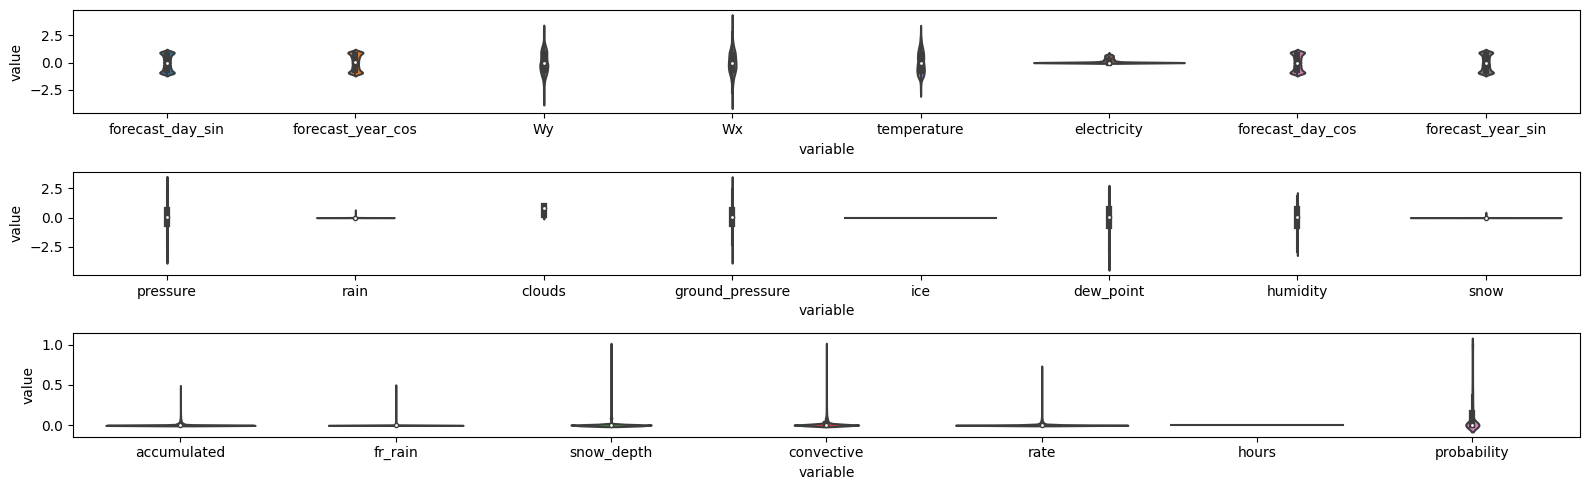

In [20]:
plt.figure(figsize=(16, 5))

num_cols_forecast = forecast_processed.select_dtypes(include=np.number).columns

plt.subplot(311)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, :8])
sns.violinplot(data= melted_forecast_df.sample(frac=0.25), x='variable', y='value')

plt.subplot(312)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, 8:16])
sns.violinplot(data= melted_forecast_df.sample(frac=0.25), x='variable', y='value')
plt.tight_layout()

plt.subplot(313)
melted_forecast_df = pd.melt(forecast_processed[num_cols_forecast].iloc[:, 16:])
sns.violinplot(data= melted_forecast_df.sample(frac=0.25), x='variable', y='value')
plt.tight_layout()

In [21]:
forecast_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45864 entries, 0 to 45863
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   local_time           45864 non-null  datetime64[ns, UTC]
 1   electricity          45864 non-null  float64            
 2   forecast_day_sin     45864 non-null  float64            
 3   forecast_day_cos     45864 non-null  float64            
 4   forecast_year_sin    45864 non-null  float64            
 5   forecast_year_cos    45864 non-null  float64            
 6   Wx                   45864 non-null  float32            
 7   Wy                   45864 non-null  float32            
 8   temperature          45864 non-null  float32            
 9   dew_point            45864 non-null  float32            
 10  pressure             45864 non-null  float32            
 11  ground_pressure      45864 non-null  float32            
 12  humidity          

# 4. Sequencing

## 4.1 Photovoltaic Data

The goal here is to train the model on a high number of sequences. Time series data have that in particular that 

In [22]:
#### Parameters ################
#################################

INPUT_WIDTH = 48
LABEL_WIDTH = 24
SHIFT = 36

class SequenceGenerator:
    """ """

    def __init__(
        self,
        input_width: int,
        label_width: int,
        shift: int,
        number_sequences: int,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame = None,
        test_df: pd.DataFrame = None,
        label_columns: List[str] = None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.number_of_sequences = number_sequences
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, self.total_window_size)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Number of sequences: {self.number_of_sequences}",
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.labels_slice, :]
        if self.label_columns is not None:
            labels = np.stack(
                [labels[:, self.column_indices[name]] for name in self.label_columns],
                axis=-1,
            )

        return inputs, labels

    def make_dataset(self, data: pd.DataFrame):
        "Create a dataset of x sequences of features and labels"
        data = np.array(data)
        last_full_sequence_start = len(data) - self.total_window_size
        inputs, labels = [], []

        for n in tqdm(range(self.number_of_sequences)):
            random_start = np.random.randint(0, last_full_sequence_start)
            input, label = self.split_window(data[random_start:])

            inputs.append(torch.tensor(input, dtype=torch.float32))
            labels.append(torch.tensor(label, dtype=torch.float32))

        inputs = torch.cat(inputs).view(self.number_of_sequences, self.input_width, -1)
        labels = torch.cat(labels).view(self.number_of_sequences, self.label_width, -1)
        return TensorDataset(inputs, labels)

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


seq_pv = SequenceGenerator(input_width= INPUT_WIDTH,
                              label_width= LABEL_WIDTH,
                              shift= SHIFT,
                              number_sequences= 10_000,
                              train_df= pv_processed,
                              label_columns= ['electricity'])

seq_pv

Number of sequences: 10000
Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]
Label column name(s): ['electricity']

## 4.2 Forecast Data

In [24]:
class SequenceForecastDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        number_days_forecast: int = 1,
        label_columns: List[str] = None,
    ):
        self.df = df.copy().astype("float32")
        self.forecast_hours = number_days_forecast * 24
        self.number_of_sequences = len(self.df) // self.forecast_hours

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(self.df.columns)}
        self.feature_columns = [
            col for col in self.df.columns if col not in self.label_columns
        ]

    def __len__(self):
        return self.number_of_sequences

    def __getitem__(self, index):
        inputs = self.df[self.feature_columns].values
        if self.label_columns is not None:
            labels = self.df[[name for name in self.label_columns]].values
        else:
            labels = self.df["electricity"].values
        return inputs.reshape(self.number_of_sequences, self.forecast_hours, -1)[index], \
                labels.reshape(self.number_of_sequences, self.forecast_hours, -1)[index]

    def __repr__(self):
        return "\n".join(
            [
                f"Number of sequences: {self.number_of_sequences}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get a random one from the dataset
            random_idx = np.random.randint(0, self.number_of_sequences)
            result = self[random_idx]
            # And cache it for next time
            self._example = result
        return result

seq_forecast = SequenceForecastDataset(forecast_processed.select_dtypes(include=np.number), label_columns=['electricity'])
seq_forecast

Number of sequences: 1911
Label column name(s): ['electricity']

In [ ]:
class SequenceForecastDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        number_days_forecast: int = 1,
        label_columns: List[str] = None,
    ):
        self.df = df.copy().astype("float32")
        self.forecast_hours = number_days_forecast * 24
        self.number_of_sequences = len(self.df) // self.forecast_hours

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(self.df.columns)}
        self.feature_columns = [
            col for col in self.df.columns if col not in self.label_columns
        ]

    def __len__(self):
        return self.number_of_sequences

    def __getitem__(self, index):
        inputs = self.df[self.feature_columns].values
        if self.label_columns is not None:
            labels = self.df[[name for name in self.label_columns]].values
        else:
            labels = self.df["electricity"].values
        return inputs.reshape(self.number_of_sequences, self.forecast_hours, -1)[index], \
                labels.reshape(self.number_of_sequences, self.forecast_hours, -1)[index]

    def __repr__(self):
        return "\n".join(
            [
                f"Number of sequences: {self.number_of_sequences}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get a random one from the dataset
            random_idx = np.random.randint(0, self.number_of_sequences)
            result = self[random_idx]
            # And cache it for next time
            self._example = result
        return result

seq_forecast = SequenceForecastDataset(forecast_processed.select_dtypes(include=np.number), label_columns=['electricity'])
seq_forecast[0]

# 5. Deep Learning

## 5.1 Split the data

In [24]:
# Split the PV data

column_indices = {name: i for i, name in enumerate(pv_processed.columns)}

n = len(pv_processed)
train_df_pv = pv_processed[0:int(n*0.7)]
val_df_pv = pv_processed[int(n*0.7):int(n*0.9)]
test_df_pv = pv_processed[int(n*0.9):]

In [25]:
# Split the Forecast data
# Careful: split must be done for 24h data

column_indices = {name: i for i, name in enumerate(forecast_processed.columns)}

n = len(forecast_processed)
train_df_forecast = forecast_processed[0:int(n*0.7 / 24) * 24]
val_df_forecast = forecast_processed[int(n*0.7 / 24) * 24:int(n*0.9 / 24) * 24]
test_df_forecast = forecast_processed[int(n*0.9 / 24) * 24:]

## 5.2 Baseline metrics

### 5.2.1 Compute regression metrics function

In [26]:
def compute_regression_metrics(model, dataloader):
    y_preds = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model.forward(inputs)
            y_preds.append(outputs.cpu())
            labels.append(targets.cpu())

    y_preds = torch.cat(y_preds)
    labels = torch.cat(labels)

    # Compute metrics
    mse = torch.mean((y_preds - labels) ** 2)
    rmse = mse ** 0.5
    mae = torch.mean(abs(y_preds - labels))
    r2 = 1 - torch.sum((y_preds - labels) ** 2) / torch.sum(y_preds - torch.mean(labels) ** 2)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

### 5.2.2 Photovoltaic data

In [27]:
sequences_pv = SequenceGenerator(input_width= INPUT_WIDTH,
                              label_width= LABEL_WIDTH,
                              shift= SHIFT,
                              number_sequences= 10_000,
                              train_df= train_df_pv[num_cols_pv],
                              val_df= val_df_pv[num_cols_pv],
                              test_df= test_df_pv[num_cols_pv],
                              label_columns= ['electricity'])

train_dataset_pv = sequences_pv.train
val_dataset_pv = sequences_pv.val
test_dataset_pv = sequences_pv.test

100%|██████████| 10000/10000 [00:00<00:00, 14827.69it/s]


In [28]:
class BaselinePV(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x[:, 12:-12, 4]
        return x.view(len(x), -1, 1)


In [29]:
test_loader_pv = DataLoader(test_dataset_pv, batch_size= 32, shuffle= True)
baseline_pv = compute_regression_metrics(BaselinePV(), test_loader_pv)

print("Baseline Metrics:", baseline_pv)

Baseline Metrics: {'mse': tensor(0.0179), 'rmse': tensor(0.1337), 'mae': tensor(0.0615), 'r2': tensor(0.8439)}


### 5.2.3 Forecast data 

In [30]:
# stick day_ahead and day_before electricity data to the forecast data
pv_data['local_time'] = pd.to_datetime(pv_data['local_time'], utc= True)
merged_forecast_pv = pd.merge(pv_data[['local_time', 'electricity']], forecast_clean, left_on='local_time', right_on= 'prediction_utc_time', how='inner')
merged_forecast_pv = merged_forecast_pv.rename(columns= {'electricity': 'electricity_day_ahead'})

merged_forecast_pv['baseline_day_utc_time'] = merged_forecast_pv['prediction_utc_time'] - dt.timedelta(days= 2)
merged_forecast_pv = pd.merge(pv_data[['local_time', 'electricity']], merged_forecast_pv, left_on='local_time', right_on= 'baseline_day_utc_time', how='inner')
merged_forecast_pv = merged_forecast_pv.rename(columns= {'electricity': 'electricity_day_before'})

time_cols_mask = [col for col in merged_forecast_pv.columns if 'time' not in col]

baseline_forecast_df = merged_forecast_pv[time_cols_mask]
baseline_forecast_dataset = SequenceForecastDataset(df= baseline_forecast_df,
                                                label_columns= ['electricity_day_ahead'])
display(baseline_forecast_dataset.df)

,electricity_day_before,electricity_day_ahead,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed,wind_deg,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,0.0,0.0,11.32,8.95,1004.539978,999.000000,85.199997,100.0,7.20,256.970001,0.33,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00
1,0.0,0.0,11.61,9.33,1004.570007,998.989990,85.790001,100.0,6.63,264.929993,0.24,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93
2,0.0,0.0,11.88,9.72,1004.760010,999.140015,86.470001,100.0,5.95,272.799988,0.19,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83
3,0.0,0.0,11.96,9.95,1005.140015,999.469971,87.400002,99.0,5.53,278.609985,0.15,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73
4,0.0,0.0,11.73,9.91,1005.750000,1000.030029,88.480003,98.0,5.63,281.290009,0.11,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45859,0.0,0.0,14.22,9.86,1011.669983,1005.960022,74.970001,100.0,7.52,224.029999,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
45860,0.0,0.0,14.13,9.57,1011.770020,1006.059998,73.919998,100.0,7.54,220.160004,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
45861,0.0,0.0,14.09,9.18,1011.909973,1006.210022,72.199997,100.0,7.56,217.789993,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00
45862,0.0,0.0,14.07,8.75,1012.140015,1006.440002,70.220001,98.0,7.54,218.410004,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00


In [31]:
# Split the Forecast data
# Careful: split must be done for 24h data

column_indices = {name: i for i, name in enumerate(baseline_forecast_df.columns)}

n = len(baseline_forecast_df)
train_baseline_df_forecast = baseline_forecast_df[0:int(n*0.7 / 24) * 24]
val_baseline_df_forecast = baseline_forecast_df[int(n*0.7 / 24) * 24:int(n*0.9 / 24) * 24]
test_df_baseline_forecast = baseline_forecast_df[int(n*0.9 / 24) * 24:]

In [32]:
test_baseline_dataset = SequenceForecastDataset(df= test_df_baseline_forecast,
                                            label_columns= ['electricity_day_ahead'])

test_baseline_loader_forecast = DataLoader(test_baseline_dataset, batch_size= 32, shuffle= True)

In [33]:
class BaselineForecast(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x[:, :, 0]
        return x.view(len(x), -1, 1)

baseline_forecast = compute_regression_metrics(BaselineForecast(), test_baseline_loader_forecast)
print("Baseline Metrics:", baseline_forecast)

Baseline Metrics: {'mse': tensor(0.0171), 'rmse': tensor(0.1306), 'mae': tensor(0.0592), 'r2': tensor(0.8568)}


## 5.3 Prepare the datasets and dataloaders

In [34]:
sequences_pv = SequenceGenerator(input_width= INPUT_WIDTH,
                              label_width= LABEL_WIDTH,
                              shift= SHIFT,
                              number_sequences= 10_000,
                              train_df= train_df_pv[num_cols_pv],
                              val_df= val_df_pv[num_cols_pv],
                              test_df= test_df_pv[num_cols_pv],
                              label_columns= ['electricity'])

train_dataset_pv = sequences_pv.train
val_dataset_pv = sequences_pv.val
test_dataset_pv = sequences_pv.test

train_loader_pv = DataLoader(train_dataset_pv, batch_size= 32, shuffle= True)
val_loader_pv = DataLoader(val_dataset_pv, batch_size= 32, shuffle= True)
test_loader_pv = DataLoader(test_dataset_pv, batch_size= 32, shuffle= True)

100%|██████████| 10000/10000 [00:00<00:00, 13308.64it/s]


In [35]:
train_dataset_forecast = SequenceForecastDataset(df= train_df_forecast.select_dtypes(include=np.number), label_columns=['electricity'])
val_dataset_forecast = SequenceForecastDataset(df= val_df_forecast.select_dtypes(include=np.number), label_columns=['electricity'])
test_dataset_forecast = SequenceForecastDataset(df= test_df_forecast.select_dtypes(include=np.number), label_columns=['electricity'])

train_loader_forecast = DataLoader(train_dataset_forecast, batch_size= 16, shuffle= True)
val_loader_forecast = DataLoader(val_dataset_forecast, batch_size= 16, shuffle= True)
test_loader_forecast = DataLoader(test_dataset_forecast, batch_size= 16, shuffle= True)

## 5.4 Simple LSTM and RNN models

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, p: int):
        super(LSTMModel, self).__init__()
        self.n_features = p
        self.lstm = nn.LSTM(p, 24, batch_first= True)
        self.linear = nn.Linear(24,24)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.tanh(x)
        x = self.linear(x[:,-1,:])
        return x.view(len(x), -1, 1)

In [37]:
class RNNModel(nn.Module):
    def __init__(self, p: int):
        super(RNNModel, self).__init__()
        self.n_features = p
        self.lstm = nn.RNN(p, 24, batch_first= True)
        self.linear = nn.Linear(24,24)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.tanh(x)
        x = self.linear(x[:,-1,:])
        return x.view(len(x), -1, 1)

In [38]:
train_loader_forecast.__len__(), val_loader_forecast.__len__(), test_loader_forecast.__len__()

(84, 24, 12)

In [63]:
############# Data ##############
dataset = 'pv'  # ['pv', 'forecast']

########## Parameters #########
batch_size = 16
learning_rate = 1e-3
EPOCHS = 3
DATASET = dataset

if DATASET == "pv":
    train_dataset = sequences_pv.train
    val_dataset = sequences_pv.val
    test_dataset = sequences_pv.test
    n_features = train_dataset.tensors[0].shape[-1]
else:
    train_dataset = train_dataset_forecast
    val_dataset = val_dataset_forecast
    test_dataset = test_dataset_forecast
    n_features = train_dataset.example[0].shape[-1]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = RNNModel(p=n_features)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

def training_one_epoch(model, train_dataloader, val_dataloader):
    size = len(train_dataloader.dataset)
    running_loss = 0
    earlystopping = 0
    for batch, data in enumerate(train_dataloader):
        X, y = data
        output = model(X)
        loss = loss_fn(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()
        running_loss += loss.item()
        mae = torch.mean(abs(output - y))

        if batch % 10 == 9:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"\tloss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    with torch.no_grad():
        outputs = []
        labels = []
        vsize = len(val_dataloader.dataset)
        running_vloss = 0.0

        # In evaluation mode some model specific operations can be omitted eg. dropout layer
        # Switching to evaluation mode, eg. turning off regularisation
        model.train(False)
        for j, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            outputs.append(voutputs)
            labels.append(vlabels)
            vloss = loss_fn(voutputs, vlabels)
            vmae = torch.mean(abs(voutputs - vlabels))
            running_vloss += vloss.item()

            if j % 10 == 9:
                vloss, vcurrent = vloss.item(), j * batch_size + len(vinputs)
                print(f"\tval loss: {vloss:>7f}  [{vcurrent:>5d}/{vsize:>5d}]")

        model.train(True)
    return loss, vloss, mae, vmae

history = defaultdict(list)
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch + 1}:")
    model.train()
    loss, vloss, mae, vmae = training_one_epoch(model, train_loader, val_loader)
    history["loss"].append(loss)
    history["val_loss"].append(vloss)
    history["mae"].append(mae)
    history["val_mae"].append(vmae)

metrics = compute_regression_metrics(model, test_loader)

val_mae = np.min(history["val_mae"])
print("Regression Metrics:", metrics)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:
	loss: 0.095343  [  160/10000]
	loss: 0.065843  [  320/10000]
	loss: 0.029522  [  480/10000]
	loss: 0.027950  [  640/10000]
	loss: 0.044092  [  800/10000]
	loss: 0.037413  [  960/10000]
	loss: 0.021688  [ 1120/10000]
	loss: 0.027670  [ 1280/10000]
	loss: 0.025806  [ 1440/10000]
	loss: 0.023398  [ 1600/10000]
	loss: 0.024238  [ 1760/10000]
	loss: 0.021015  [ 1920/10000]
	loss: 0.026062  [ 2080/10000]
	loss: 0.019603  [ 2240/10000]
	loss: 0.017616  [ 2400/10000]
	loss: 0.020634  [ 2560/10000]
	loss: 0.020692  [ 2720/10000]
	loss: 0.017997  [ 2880/10000]
	loss: 0.020633  [ 3040/10000]
	loss: 0.019370  [ 3200/10000]
	loss: 0.018837  [ 3360/10000]
	loss: 0.021081  [ 3520/10000]
	loss: 0.016618  [ 3680/10000]
	loss: 0.022453  [ 3840/10000]
	loss: 0.016607  [ 4000/10000]
	loss: 0.015852  [ 4160/10000]
	loss: 0.016377  [ 4320/10000]
	loss: 0.020919  [ 4480/10000]
	loss: 0.019779  [ 4640/10000]
	loss: 0.016495  [ 4800/10000]
	loss: 0.020288  [ 4960/10000]
	loss: 0.016910  [ 5120/10000]

 33%|███▎      | 1/3 [00:06<00:13,  6.87s/it]

Epoch 2:
	loss: 0.014065  [  160/10000]
	loss: 0.010048  [  320/10000]
	loss: 0.013606  [  480/10000]
	loss: 0.011761  [  640/10000]
	loss: 0.011243  [  800/10000]
	loss: 0.013409  [  960/10000]
	loss: 0.015731  [ 1120/10000]
	loss: 0.012616  [ 1280/10000]
	loss: 0.012649  [ 1440/10000]
	loss: 0.008495  [ 1600/10000]
	loss: 0.017888  [ 1760/10000]
	loss: 0.012786  [ 1920/10000]
	loss: 0.012409  [ 2080/10000]
	loss: 0.010351  [ 2240/10000]
	loss: 0.014883  [ 2400/10000]
	loss: 0.011570  [ 2560/10000]
	loss: 0.007911  [ 2720/10000]
	loss: 0.010428  [ 2880/10000]
	loss: 0.009156  [ 3040/10000]
	loss: 0.008999  [ 3200/10000]
	loss: 0.008507  [ 3360/10000]
	loss: 0.011132  [ 3520/10000]
	loss: 0.007291  [ 3680/10000]
	loss: 0.011352  [ 3840/10000]
	loss: 0.010368  [ 4000/10000]
	loss: 0.008517  [ 4160/10000]
	loss: 0.014074  [ 4320/10000]
	loss: 0.012144  [ 4480/10000]
	loss: 0.011076  [ 4640/10000]
	loss: 0.013401  [ 4800/10000]
	loss: 0.008414  [ 4960/10000]
	loss: 0.008448  [ 5120/10000]

 67%|██████▋   | 2/3 [00:13<00:06,  7.00s/it]

	val loss: 0.008706  [ 9600/10000]
	val loss: 0.011083  [ 9760/10000]
	val loss: 0.011652  [ 9920/10000]
Epoch 3:
	loss: 0.008745  [  160/10000]
	loss: 0.010473  [  320/10000]
	loss: 0.010175  [  480/10000]
	loss: 0.012762  [  640/10000]
	loss: 0.013471  [  800/10000]
	loss: 0.010285  [  960/10000]
	loss: 0.008091  [ 1120/10000]
	loss: 0.010799  [ 1280/10000]
	loss: 0.010114  [ 1440/10000]
	loss: 0.006822  [ 1600/10000]
	loss: 0.009599  [ 1760/10000]
	loss: 0.011630  [ 1920/10000]
	loss: 0.009449  [ 2080/10000]
	loss: 0.008078  [ 2240/10000]
	loss: 0.010503  [ 2400/10000]
	loss: 0.013796  [ 2560/10000]
	loss: 0.008800  [ 2720/10000]
	loss: 0.013617  [ 2880/10000]
	loss: 0.010773  [ 3040/10000]
	loss: 0.009091  [ 3200/10000]
	loss: 0.008651  [ 3360/10000]
	loss: 0.009552  [ 3520/10000]
	loss: 0.010225  [ 3680/10000]
	loss: 0.010948  [ 3840/10000]
	loss: 0.008219  [ 4000/10000]
	loss: 0.013322  [ 4160/10000]
	loss: 0.007605  [ 4320/10000]
	loss: 0.010375  [ 4480/10000]
	loss: 0.015095  [

100%|██████████| 3/3 [00:20<00:00,  6.77s/it]

	val loss: 0.010708  [ 9920/10000]


Regression Metrics: {'mse': tensor(0.0108), 'rmse': tensor(0.1041), 'mae': tensor(0.0638), 'r2': tensor(0.8955)}


# 6. Evaluate model

In [65]:
model.eval()
compute_regression_metrics(model, test_loader_pv)

{'mse': tensor(0.0107),
 'rmse': tensor(0.1033),
 'mae': tensor(0.0633),
 'r2': tensor(0.8976)}

# 7. Make a prediction

Let's make a prediction with our model. <br>
We take as an input the day we want to predict the PV production

In [66]:
from datetime import timedelta
input_pred = "2022-07-06"

# Compute the necessary datetime objects for the BQ querying
dt_day_ahead_begin = pd.to_datetime(input_pred, utc=True)
dt_day_ahead_end = dt_day_ahead_begin + np.timedelta64(23, 'h')

dt_pv_data_begin = dt_day_ahead_begin - np.timedelta64(2, 'D')
dt_pv_data_end = dt_day_ahead_end -np.timedelta64(2, 'D')

dt_noon_weather_forecast = dt_day_ahead_begin - np.timedelta64(12, 'h')

Query the data from BigQuery directly.<br>
This way we work in real-life scenario: we have a raw weather forecast for the day ahead

Set-up the BQ query

In [67]:
GCP_PROJECT = os.environ.get("GCP_PROJECT")
BQ_DATASET = os.environ.get("BQ_DATASET")

def query_bq_data(
        gcp_project:str,
        query:str,
    ) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """

    print(Fore.BLUE + "\nLoad data from BigQuery server..." + Style.RESET_ALL)
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()

    print(f"✅ Data loaded, with shape {df.shape}")

    return df


In [78]:
# Query raw PV data from BUCKET BigQuery
query_pv = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.raw_pv
    WHERE _0 BETWEEN {int(dt_pv_data_begin.timestamp()) * 1000}
                AND {int(dt_noon_weather_forecast.timestamp()) * 1000}
    ORDER BY _0
"""

# Retrieve data from BigQuery
data_pv_query = query_bq_data(
    query=query_pv,
    gcp_project=GCP_PROJECT
)

# Query raw historical weather forecast data from BigQuery
query_forecast = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.raw_weather_forecast
    WHERE forecast_dt_unixtime = {int(dt_noon_weather_forecast.timestamp())}
    ORDER BY forecast_dt_unixtime, slice_dt_unixtime
"""

data_forecast_query = query_bq_data(
    query=query_forecast,
    gcp_project=GCP_PROJECT
)

# fix issue with column name in BigQuery (the issue is just in the notebook)
try:
    assert data_forecast_query.shape[1] == forecast_data.shape[1]
    data_forecast_query.columns = forecast_data.columns
except AssertionError as e:
    print(e)


Load data from BigQuery server...
✅ Data loaded, with shape (37, 8)

Load data from BigQuery server...
✅ Data loaded, with shape (385, 24)


Clean and preprocess the PV data 

In [79]:
data_pv_query["local_time"] = pd.to_datetime(data_pv_query["local_time"], utc=True)

# Clean data for the first 24h only
timestamp_pv_data_end = int(dt_pv_data_end.timestamp()) * 1000
data_pv_processed = preprocess_pv.transform(data_pv_query.query("_0 <= @timestamp_pv_data_end"))

In [80]:
data_pv_processed

,Time Encoder__day_sin,Time Encoder__day_cos,Time Encoder__year_sin,Time Encoder__year_cos,Passthrough__local_time,Passthrough__electricity
0,-3.524615e-12,1.000000e+00,-0.030423,-0.999537,2022-07-04 00:00:00+00:00,0.000
1,2.588190e-01,9.659258e-01,-0.031139,-0.999515,2022-07-04 01:00:00+00:00,0.000
2,5.000000e-01,8.660254e-01,-0.031856,-0.999492,2022-07-04 02:00:00+00:00,0.000
3,7.071068e-01,7.071068e-01,-0.032572,-0.999469,2022-07-04 03:00:00+00:00,0.013
4,8.660254e-01,5.000000e-01,-0.033288,-0.999446,2022-07-04 04:00:00+00:00,0.047
5,9.659258e-01,2.588190e-01,-0.034005,-0.999422,2022-07-04 05:00:00+00:00,0.106
6,1.000000e+00,6.087959e-12,-0.034721,-0.999397,2022-07-04 06:00:00+00:00,0.277
7,9.659258e-01,-2.588190e-01,-0.035437,-0.999372,2022-07-04 07:00:00+00:00,0.445
8,8.660254e-01,-5.000000e-01,-0.036154,-0.999346,2022-07-04 08:00:00+00:00,0.582
9,7.071068e-01,-7.071068e-01,-0.036870,-0.999320,2022-07-04 09:00:00+00:00,0.678


Clean and preprocess the Weather forecast data 

In [72]:
# Clean data
data_forecast_clean = clean_forecast_data(data_forecast_query)

data_forecast_processed = forecast_transformer.transform(data_forecast_clean)

dataframe size:  72.31 kB
optimized size by 46.0 %
new dataframe size:  39.23  kB


In [73]:
data_forecast_processed

,Time Encoder__forecast_day_sin,Time Encoder__forecast_day_cos,Time Encoder__forecast_year_sin,Time Encoder__forecast_year_cos,Wind Encoder__Wx,Wind Encoder__Wy,Std__temperature,Std__dew_point,Std__pressure,Std__ground_pressure,...,MinMax__ice,MinMax__fr_rain,MinMax__convective,MinMax__snow_depth,MinMax__accumulated,MinMax__hours,MinMax__rate,MinMax__probability,Passthrough__utc_time,Passthrough__prediction_utc_time
0,-9.479453e-12,1.000000e+00,-0.064788,-0.997899,0.666512,1.967812,0.777299,0.427908,0.487538,0.500659,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 00:00:00+00:00
1,2.588190e-01,9.659258e-01,-0.065503,-0.997852,1.463501,2.959351,0.673181,0.551467,0.493805,0.504859,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 01:00:00+00:00
2,5.000000e-01,8.660254e-01,-0.066218,-0.997805,1.630542,1.842930,0.539315,0.675026,0.497987,0.509059,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.01,2022-07-05 12:00:00+00:00,2022-07-06 02:00:00+00:00
3,7.071068e-01,7.071068e-01,-0.066933,-0.997757,0.792792,0.183813,0.437676,0.760073,0.510521,0.520620,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 03:00:00+00:00
4,8.660254e-01,5.000000e-01,-0.067648,-0.997709,0.102336,-0.453077,0.410407,0.772910,0.535589,0.544781,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 04:00:00+00:00
5,9.659258e-01,2.588190e-01,-0.068364,-0.997660,0.116617,-0.631209,0.451311,0.742421,0.566925,0.576297,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 05:00:00+00:00
6,1.000000e+00,1.204280e-11,-0.069079,-0.997611,0.452934,-0.650232,0.538075,0.705514,0.595129,0.604665,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,2022-07-05 12:00:00+00:00,2022-07-06 06:00:00+00:00
7,9.659258e-01,-2.588190e-01,-0.069794,-0.997561,0.690099,-0.688152,0.649630,0.687863,0.613931,0.623575,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.003057,0.05,2022-07-05 12:00:00+00:00,2022-07-06 07:00:00+00:00
8,8.660254e-01,-5.000000e-01,-0.070509,-0.997511,0.788706,-0.748226,0.764904,0.655770,0.620198,0.631981,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.006496,0.11,2022-07-05 12:00:00+00:00,2022-07-06 08:00:00+00:00
9,7.071068e-01,-7.071068e-01,-0.071224,-0.997460,0.807617,-0.746298,0.859106,0.559490,0.616022,0.628827,...,0.0,0.0,0.011482,0.0,0.0,0.0,0.008407,0.14,2022-07-05 12:00:00+00:00,2022-07-06 09:00:00+00:00


In [81]:
if DATASET == "pv":
    # model = load_model(forecast_features=False)
    assert model is not None
    X = data_pv_processed.select_dtypes(include=np.number)
    X = np.expand_dims(X.values, axis=0)

else:
    # model = load_model()
    assert model is not None
    X = data_forecast_processed.select_dtypes(include=np.number)
    X = np.expand_dims(X.values, axis=0)

    X_tensor = torch.tensor(X, dtype= torch.float32)
X.shape, model

((1, 24, 5),
 RNNModel(
   (lstm): RNN(5, 24, batch_first=True)
   (linear): Linear(in_features=24, out_features=24, bias=True)
 ))

In [82]:
model.eval()
X_tensor = torch.tensor(X, dtype= torch.float32)


y_pred = model.forward(X_tensor)
y_pred_df = pd.DataFrame(y_pred.detach().numpy()[0], columns=["pred"])
y_pred_df["utc_time"] = data_forecast_clean['prediction_utc_time']
y_pred_df

,pred,utc_time
0,0.516751,2022-07-06 00:00:00+00:00
1,0.442686,2022-07-06 01:00:00+00:00
2,0.360643,2022-07-06 02:00:00+00:00
3,0.260765,2022-07-06 03:00:00+00:00
4,0.158521,2022-07-06 04:00:00+00:00
5,0.081726,2022-07-06 05:00:00+00:00
6,0.044640,2022-07-06 06:00:00+00:00
7,0.030735,2022-07-06 07:00:00+00:00
8,0.015307,2022-07-06 08:00:00+00:00
9,-0.021023,2022-07-06 09:00:00+00:00


In [ ]:
y_pred_df["utc_time"] = data_forecast_clean['prediction_utc_time']
y_pred_df.info()

If you start TensorBoard at the command line and open it in a new browser tab (usually at [localhost:6006](localhost:6006)), you should see the image grid under the IMAGES tab.

## Graphing Scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

Let's define a model to categorize our image tiles, and an optimizer and loss function for training:

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # Default log_dir argument is "runs" - but it's good to be specific
# # torch.utils.tensorboard.SummaryWriter is imported above
# writer = SummaryWriter()
# # writer.close()

# # Write image data to TensorBoard log dir
# # writer.add_image('Four Fashion-MNIST Images', img_grid)
# # writer.flush()

# # To view, start TensorBoard on the command line with:
# #   tensorboard --logdir=runs
# # ...and open a browser tab to http://localhost:6006/

In [ ]:
# ############# Data ##############
# dataset = 'forecast'  # ['pv', 'forecast']

# ########## Parameters #########
# batch_size = 32
# learning_rate = 1e-3
# epochs = 10


# if dataset == 'pv':
#     train_dataset = train_dataset_pv
#     test_dataset = test_dataset_pv
#     n_features = train_dataset_pv.tensors[0].shape[-1]
# else:
#     train_dataset = train_dataset_forecast
#     test_dataset = test_dataset_forecast
#     n_features = train_dataset.example[0].shape[-1]

# train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
# test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

# model = LSTMModel(p = n_features)
# loss_fn = nn.MSELoss()
# optim = torch.optim.Adam(params= model.parameters(), lr= learning_rate)

# print(len(val_loader_forecast))
# for epoch in range(epochs):  # loop over the dataset multiple times
#     running_loss = 0.0

#     for i, data in enumerate(train_loader_forecast, 0):
#         # basic training loop
#         inputs, labels = data
#         optim.zero_grad()
#         outputs = model(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optim.step()

#         running_loss += loss.item()
#         if i % 8 == 7:    # Every 1000 mini-batches...
#             print('Batch {}'.format(i + 1))
#             # Check against the validation set
#             running_vloss = 0.0

#             # In evaluation mode some model specific operations can be omitted eg. dropout layer
#             model.train(False) # Switching to evaluation mode, eg. turning off regularisation
#             for j, vdata in enumerate(val_loader_forecast, 0):
#                 vinputs, vlabels = vdata
#                 voutputs = model(vinputs)
#                 vloss = loss_fn(voutputs, vlabels)
#                 running_vloss += vloss.item()
#             model.train(True) # Switching back to training mode, eg. turning on regularisation

#             avg_loss = running_loss / 1000
#             avg_vloss = running_vloss / len(val_loader_forecast)

#             # Log the running loss averaged per batch
#             writer.add_scalars('Training vs. Validation Loss',
#                             { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                             epoch * len(train_loader_forecast) + i)

#             running_loss = 0.0
# print('Finished Training')

# writer.flush()

Switch to your open TensorBoard and have a look at the SCALARS tab.

## Visualizing Your Model
TensorBoard can also be used to examine the data flow within your model. To do this, call the `add_graph()` method with a model and sample input. When you open 

In [ ]:
# # Again, grab a single mini-batch of images
# dataiter = iter(train_loader_forecast)
# inputs, labels = next(dataiter)

# # add_graph() will trace the sample input through your model,
# # and render it as a graph.
# writer.add_graph(model, inputs)
# writer.flush()
# writer.close

In [ ]:
# baseline_pv, baseline_forecast